In [4]:
import torch.optim as optim
from pytorch_model_summary import summary

import matplotlib.pyplot as plt


In [106]:
# Import functions get_digits_loaders, get_mnist_loaders, get_labels 
%run Datasets.ipynb

# Import baseline RNN, reservoir RNN
%run Networks.ipynb

# Import the training and evaluation functions + their corresponding auxiliary function + all plot functions 
%run Operations.ipynb

# Import the evolutionary algorithm
%run EA.ipynb

### Define all parameters

In [97]:
# Data parameters
input_size_digits = 64  # 8 * 8 pixels
input_size_mnist = 784  # 28 * 28 pixels
n_labels = 10
batch_size= 50
train_loader_digits, val_loader_digits, test_loader_digits = get_digits_loaders(batch_size)
LABELS = get_labels()


# Network / Learning parameters
reservoir_size = 128 # for reservoir
n_hidden = 128 # for baseline
lr_SGD = 0.0001
momentum_SGD = 0.9
backprop_epochs = 5 # with backprop, only applicable in the evolutionairy approach. 
T = 5
loss_function = nn.NLLLoss(reduction='sum')
max_loss_iter = 10  # not really used yet


# EA parameters
population_size = 20
generations = 25 # epochs without backprop
mutate_opt = 'diff_mutation'  # Options: 'random_perturbation' , 'diff_mutation'
perturb_rate = 1 #If using diff mutation
sample_dist = 'uniform'       # If using random perturbation, options: 'gaussian' , 'uniform'
select_opt = 'classification_error'
select_mech = 'keep_k_best'   # Options: 'keep_k_best'= half of the parents , 'merge_all'
k_best = population_size // 4   # Keep 1/4 of the population as the best for new pop, the rest is new. 
offspring_ratio = 2    # When mutating, create k times as much children as there are parents. 


# Run all models for same amount of time, but make a distinction in epochs for the evolutionairy approach .
n_epochs = backprop_epochs + generations

### Run baseline model

In [98]:
bl_model_digits = Baseline_RNN(input_size_digits, n_hidden, n_labels, T, dataset = 'Digits')
optimizer_digits = optim.SGD([p for p in bl_model_digits.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
loss_function = nn.NLLLoss(reduction='sum') # Mean is also possible.

trained_bl_digits = training(bl_model_digits, train_loader_digits, val_loader_digits, n_epochs, optimizer_digits, loss_function, max_loss_iter)

Training started for 30 epochs.
Epoch: 0 - Loss of: 0.2729749734061105 - Classification Error of: 9.428570747375488
Epoch: 1 - Loss of: 0.18841095856257847 - Classification Error of: 6.0
Epoch: 2 - Loss of: 0.2239627800668989 - Classification Error of: 7.714285850524902
Epoch: 3 - Loss of: 0.190308929170881 - Classification Error of: 5.714285850524902
Epoch: 4 - Loss of: 0.17142081805637904 - Classification Error of: 4.857142925262451
Epoch: 5 - Loss of: 0.1352185228892735 - Classification Error of: 3.4285712242126465
Epoch: 6 - Loss of: 0.18856230531420026 - Classification Error of: 5.4285712242126465
Epoch: 7 - Loss of: 0.17900103773389545 - Classification Error of: 5.142857074737549
Epoch: 8 - Loss of: 0.14243876525333948 - Classification Error of: 3.4285712242126465
Epoch: 9 - Loss of: 0.15781316450663976 - Classification Error of: 4.571428298950195
Epoch: 10 - Loss of: 0.13628320932388305 - Classification Error of: 3.7142858505249023
Epoch: 11 - Loss of: 0.15584757089614867 - Clas

### Run EA Reservoir RNN 

In [99]:
# Initialize population - train by backprop for a few epochs. 
reservoir_set_digits = []
ea = EA(population_size, val_loader_digits, loss_function, input_size_digits, reservoir_size, n_labels)

for i in range(population_size):
    res_evo_digits = Reservoir_RNN(input_size_digits, reservoir_size, n_labels, T, dataset = 'Digits')
    optimizer_evo_digits = optim.SGD([p for p in res_evo_digits.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
    trained_evo_digits = training(res_evo_digits, train_loader_digits, val_loader_digits, backprop_epochs, optimizer_evo_digits, loss_function, max_loss_iter)
    reservoir_set_digits.append(trained_evo_digits)
        
# Initialize the population
new_pop = reservoir_set_digits

# Perform ea steps
for i in range(generations):
    new_pop = ea.step(new_pop, mutate_opt, perturb_rate, select_opt, select_mech, offspring_ratio, sample_dist, k_best)

# Sort population after x amount of generations, based on classification error or loss performance
if select_opt == 'classification_error':
    best_pop_digits = sorted(new_pop, key=lambda k: k['class_error_results'][-1] , reverse=False) 
elif select_opt == 'loss':
    best_pop_digits = sorted(new_pop, key=lambda k: k['loss_results'][-1] , reverse=False)


Training started for 5 epochs.
Epoch: 0 - Loss of: 2.246742924281529 - Classification Error of: 62.85714340209961
Epoch: 1 - Loss of: 2.1611871337890625 - Classification Error of: 39.71428680419922
Epoch: 2 - Loss of: 2.0765691266741073 - Classification Error of: 31.142858505249023
Epoch: 3 - Loss of: 1.9960456194196428 - Classification Error of: 27.142858505249023
Epoch: 4 - Loss of: 1.9216622488839286 - Classification Error of: 26.28571319580078
Training started for 5 epochs.
Epoch: 0 - Loss of: 2.2554913330078126 - Classification Error of: 62.85714340209961
Epoch: 1 - Loss of: 2.1832027762276787 - Classification Error of: 35.14285659790039
Epoch: 2 - Loss of: 2.111334272112165 - Classification Error of: 32.0
Epoch: 3 - Loss of: 2.0424158586774555 - Classification Error of: 27.714284896850586
Epoch: 4 - Loss of: 1.977408229282924 - Classification Error of: 20.85714340209961
Training started for 5 epochs.
Epoch: 0 - Loss of: 2.2593587384905134 - Classification Error of: 56.28571319580

Epoch: 3 - Loss of: 2.041272953578404 - Classification Error of: 16.85714340209961
Epoch: 4 - Loss of: 1.9748655264718191 - Classification Error of: 19.428571701049805
Training started for 5 epochs.
Epoch: 0 - Loss of: 2.2535567583356584 - Classification Error of: 56.85714340209961
Epoch: 1 - Loss of: 2.1760821097237724 - Classification Error of: 44.28571319580078
Epoch: 2 - Loss of: 2.0989176722935268 - Classification Error of: 28.285715103149414
Epoch: 3 - Loss of: 2.0266715131487163 - Classification Error of: 20.0
Epoch: 4 - Loss of: 1.9564315577915736 - Classification Error of: 15.714285850524902
Possible candidates for optimization
Epoch: 5 - Loss of: 1.1465188707624163 - Classification Error of: 32.57143020629883
Epoch: 5 - Loss of: 1.721428004673549 - Classification Error of: 44.28571319580078
Epoch: 5 - Loss of: 1.6883917890276228 - Classification Error of: 44.0
Epoch: 5 - Loss of: 1.7363014657156808 - Classification Error of: 31.428571701049805
Epoch: 5 - Loss of: 1.7354375130

Epoch: 6 - Loss of: 1.1400494820731026 - Classification Error of: 33.14285659790039
Epoch: 6 - Loss of: 1.4815689522879465 - Classification Error of: 40.0
Epoch: 6 - Loss of: 1.1789532688685826 - Classification Error of: 26.0
Epoch: 6 - Loss of: 1.5291072300502233 - Classification Error of: 34.57142639160156
Epoch: 6 - Loss of: 1.3131375449044365 - Classification Error of: 26.85714340209961
Epoch: 6 - Loss of: 1.7012442452566965 - Classification Error of: 26.85714340209961
Epoch: 6 - Loss of: 1.3428677804129465 - Classification Error of: 22.0
Epoch: 6 - Loss of: 0.9563524954659598 - Classification Error of: 27.142858505249023
Epoch: 6 - Loss of: 1.3720970262799945 - Classification Error of: 22.0
Epoch: 6 - Loss of: 1.1211122894287109 - Classification Error of: 29.14285659790039
Epoch: 6 - Loss of: 0.8518122645786831 - Classification Error of: 11.714285850524902
Epoch: 6 - Loss of: 1.3871702575683593 - Classification Error of: 24.285715103149414
Epoch: 6 - Loss of: 1.3787595912388393 - 

Epoch: 7 - Loss of: 1.2895248740059988 - Classification Error of: 49.71428680419922
Epoch: 7 - Loss of: 1.2627224404471262 - Classification Error of: 30.28571319580078
Epoch: 7 - Loss of: 1.287814178466797 - Classification Error of: 34.85714340209961
Epoch: 7 - Loss of: 0.9414488220214844 - Classification Error of: 28.0
Epoch: 7 - Loss of: 0.7637110355922154 - Classification Error of: 20.571428298950195
Epoch: 7 - Loss of: 1.1688744245256697 - Classification Error of: 29.14285659790039
Epoch: 7 - Loss of: 0.9729575565883092 - Classification Error of: 21.428571701049805
Epoch: 7 - Loss of: 1.351810084751674 - Classification Error of: 26.85714340209961
Epoch: 7 - Loss of: 2.8110644967215404 - Classification Error of: 95.42857360839844
Epoch: 7 - Loss of: 1.8845944431849888 - Classification Error of: 65.14286041259766
Epoch: 7 - Loss of: 1.0868919808523996 - Classification Error of: 38.85714340209961
Epoch: 7 - Loss of: 3.061415492466518 - Classification Error of: 97.42857360839844
Epoch:

Epoch: 8 - Loss of: 2.7027318464006695 - Classification Error of: 86.0
Epoch: 8 - Loss of: 1.1148821694510325 - Classification Error of: 39.14285659790039
Epoch: 8 - Loss of: 0.878677727835519 - Classification Error of: 28.0
Epoch: 8 - Loss of: 2.7184256199428014 - Classification Error of: 61.71428680419922
Epoch: 8 - Loss of: 2.5101436723981583 - Classification Error of: 88.85714721679688
Epoch: 8 - Loss of: 1.9741829354422433 - Classification Error of: 77.14286041259766
Epoch: 8 - Loss of: 0.980238778250558 - Classification Error of: 24.571428298950195
Epoch: 8 - Loss of: 17.316827915736607 - Classification Error of: 99.42857360839844
Epoch: 8 - Loss of: 1.9480121721540178 - Classification Error of: 64.57142639160156
Epoch: 8 - Loss of: 3.9092786952427456 - Classification Error of: 99.71428680419922
Epoch: 8 - Loss of: 3.9841844395228794 - Classification Error of: 99.14285278320312
Epoch: 8 - Loss of: 2.837841230119978 - Classification Error of: 99.42857360839844
Epoch: 8 - Loss of: 

Epoch: 9 - Loss of: 1.3438910675048827 - Classification Error of: 43.14285659790039
Epoch: 9 - Loss of: 5.256597987583706 - Classification Error of: 87.14285278320312
Epoch: 9 - Loss of: 2.1447580827985493 - Classification Error of: 71.71428680419922
Epoch: 9 - Loss of: 8.43744376046317 - Classification Error of: 81.14285278320312
Epoch: 9 - Loss of: 3.3747532871791295 - Classification Error of: 93.42857360839844
Epoch: 9 - Loss of: 4.0302667236328125 - Classification Error of: 73.71428680419922
Epoch: 9 - Loss of: 9.534257550920758 - Classification Error of: 91.71428680419922
Epoch: 9 - Loss of: 1.9622869982038225 - Classification Error of: 44.57143020629883
Epoch: 9 - Loss of: 9.367366681780133 - Classification Error of: 91.71428680419922
test selection
Possible candidates for optimization
Epoch: 10 - Loss of: 4.68347412109375 - Classification Error of: 29.71428680419922
Epoch: 10 - Loss of: 1.3603848484584264 - Classification Error of: 20.0
Epoch: 10 - Loss of: 0.5456222915649414 - 

Epoch: 11 - Loss of: 36.65564069475447 - Classification Error of: 100.0
Epoch: 11 - Loss of: 12.347479858398437 - Classification Error of: 62.0
Epoch: 11 - Loss of: 21.491388288225448 - Classification Error of: 93.71428680419922
Epoch: 11 - Loss of: 2.8517762320382256 - Classification Error of: 60.57142639160156
Epoch: 11 - Loss of: 5.305935843331473 - Classification Error of: 22.285715103149414
Epoch: 11 - Loss of: 4.1364446585518975 - Classification Error of: 28.0
Epoch: 11 - Loss of: 43.30879150390625 - Classification Error of: 56.57143020629883
Epoch: 11 - Loss of: 1.0497708783830915 - Classification Error of: 21.14285659790039
Epoch: 11 - Loss of: 4.559393659319197 - Classification Error of: 42.85714340209961
Epoch: 11 - Loss of: 6.694097115652902 - Classification Error of: 20.0
Epoch: 11 - Loss of: 14.87753888811384 - Classification Error of: 92.5714340209961
Epoch: 11 - Loss of: 1.98666506086077 - Classification Error of: 40.85714340209961
Epoch: 11 - Loss of: 18.372642124720983

Epoch: 12 - Loss of: 12.103922685895647 - Classification Error of: 28.0
Epoch: 12 - Loss of: 19.138876604352678 - Classification Error of: 31.142858505249023
Epoch: 12 - Loss of: 238.0417103794643 - Classification Error of: 82.57142639160156
Epoch: 12 - Loss of: 43.51506556919643 - Classification Error of: 96.85713958740234
Epoch: 12 - Loss of: 23.873120465959822 - Classification Error of: 24.85714340209961
Epoch: 12 - Loss of: 41.78938232421875 - Classification Error of: 45.71428680419922
Epoch: 12 - Loss of: 68.43289481026785 - Classification Error of: 99.71428680419922
Epoch: 12 - Loss of: 12.561802193777902 - Classification Error of: 56.57143020629883
Epoch: 12 - Loss of: 16.2124267578125 - Classification Error of: 67.14285278320312
Epoch: 12 - Loss of: 45.844891880580356 - Classification Error of: 63.71428298950195
Epoch: 12 - Loss of: 27.582713448660716 - Classification Error of: 75.71428680419922
Epoch: 12 - Loss of: 71.24198102678571 - Classification Error of: 98.0
Epoch: 12 - 

Epoch: 13 - Loss of: 152.62605329241072 - Classification Error of: 100.0
Epoch: 13 - Loss of: 310.4452650669643 - Classification Error of: 100.0
Epoch: 13 - Loss of: 59.67830636160714 - Classification Error of: 64.0
Epoch: 13 - Loss of: 223.26577845982143 - Classification Error of: 74.5714340209961
Epoch: 13 - Loss of: 93.00221261160715 - Classification Error of: 94.0
Epoch: 13 - Loss of: 47.74826171875 - Classification Error of: 96.57142639160156
Epoch: 13 - Loss of: 249.63551618303572 - Classification Error of: 98.85713958740234
Epoch: 13 - Loss of: 215.91495256696427 - Classification Error of: 100.0
Epoch: 13 - Loss of: 350.2887332589286 - Classification Error of: 100.0
Epoch: 13 - Loss of: 63.83756068638393 - Classification Error of: 64.57142639160156
Epoch: 13 - Loss of: 111.14600027901785 - Classification Error of: 100.0
Epoch: 13 - Loss of: 14.204715837751117 - Classification Error of: 24.285715103149414
Epoch: 13 - Loss of: 13.859082728794643 - Classification Error of: 31.71428

Epoch: 14 - Loss of: 1807.140357142857 - Classification Error of: 100.0
Epoch: 14 - Loss of: 2429.06296875 - Classification Error of: 99.71428680419922
Epoch: 14 - Loss of: 83.00800571986608 - Classification Error of: 94.57142639160156
Epoch: 14 - Loss of: 1783.7839732142857 - Classification Error of: 100.0
Epoch: 14 - Loss of: 169.72975864955356 - Classification Error of: 32.0
Epoch: 14 - Loss of: 119.70638532366071 - Classification Error of: 66.57142639160156
Epoch: 14 - Loss of: 498.3015513392857 - Classification Error of: 76.0
Epoch: 14 - Loss of: 239.7100502232143 - Classification Error of: 38.0
Epoch: 14 - Loss of: 86.65016531808035 - Classification Error of: 36.57142639160156
Epoch: 14 - Loss of: 81.07460379464285 - Classification Error of: 34.28571701049805
Epoch: 14 - Loss of: 2.9734232112339565 - Classification Error of: 24.0
test selection
Possible candidates for optimization
Epoch: 15 - Loss of: 7.692593035016741 - Classification Error of: 27.428569793701172
Epoch: 15 - Los

Epoch: 16 - Loss of: 229.13431361607144 - Classification Error of: 26.571428298950195
Epoch: 16 - Loss of: 21504.597857142857 - Classification Error of: 91.42857360839844
Epoch: 16 - Loss of: 1367.2469308035713 - Classification Error of: 44.857139587402344
Epoch: 16 - Loss of: 1970.3801339285715 - Classification Error of: 95.42857360839844
Epoch: 16 - Loss of: 6097.550357142857 - Classification Error of: 90.0
Epoch: 16 - Loss of: 4058.260669642857 - Classification Error of: 79.14285278320312
Epoch: 16 - Loss of: 1178.3365178571428 - Classification Error of: 69.14285278320312
Epoch: 16 - Loss of: 2941.8832589285716 - Classification Error of: 88.28571319580078
Epoch: 16 - Loss of: 58.65639857700893 - Classification Error of: 62.28571701049805
Epoch: 16 - Loss of: 2723.7966741071427 - Classification Error of: 75.71428680419922
Epoch: 16 - Loss of: 5459.0459375 - Classification Error of: 82.85714721679688
Epoch: 16 - Loss of: 67.89829241071429 - Classification Error of: 90.0
Epoch: 16 - Lo

Epoch: 17 - Loss of: 2631.6050223214284 - Classification Error of: 55.71428680419922
Epoch: 17 - Loss of: 839.8922321428571 - Classification Error of: 48.28571319580078
Epoch: 17 - Loss of: 3183.793482142857 - Classification Error of: 90.0
Epoch: 17 - Loss of: 34134.33 - Classification Error of: 57.42856979370117
Epoch: 17 - Loss of: 740.1551060267857 - Classification Error of: 42.28571319580078
Epoch: 17 - Loss of: 7322.730803571429 - Classification Error of: 83.14286041259766
Epoch: 17 - Loss of: 528.295703125 - Classification Error of: 67.42857360839844
Epoch: 17 - Loss of: 1018.7173883928572 - Classification Error of: 46.57142639160156
Epoch: 17 - Loss of: 1444.440669642857 - Classification Error of: 68.5714340209961
Epoch: 17 - Loss of: 682.8326618303571 - Classification Error of: 48.0
Epoch: 17 - Loss of: 370.6093917410714 - Classification Error of: 16.571428298950195
Epoch: 17 - Loss of: 65376.00428571428 - Classification Error of: 100.0
Epoch: 17 - Loss of: 13.767792227608817 -

Epoch: 18 - Loss of: 56690.66285714286 - Classification Error of: 89.42857360839844
Epoch: 18 - Loss of: 13759.585 - Classification Error of: 84.0
Epoch: 18 - Loss of: 1362.5373325892858 - Classification Error of: 41.71428680419922
Epoch: 18 - Loss of: 66692.39357142858 - Classification Error of: 98.85713958740234
Epoch: 18 - Loss of: 34606.80464285714 - Classification Error of: 76.28571319580078
Epoch: 18 - Loss of: 33117.999285714286 - Classification Error of: 98.57142639160156
Epoch: 18 - Loss of: 580.1303529575893 - Classification Error of: 18.28571319580078
Epoch: 18 - Loss of: 29145.28 - Classification Error of: 97.71428680419922
Epoch: 18 - Loss of: 33276.09857142857 - Classification Error of: 89.42857360839844
Epoch: 18 - Loss of: 568.9511830357143 - Classification Error of: 61.14285659790039
Epoch: 18 - Loss of: 1853.6864732142858 - Classification Error of: 89.71427917480469
Epoch: 18 - Loss of: 17456.70625 - Classification Error of: 100.0
Epoch: 18 - Loss of: 621.806685267857

Epoch: 19 - Loss of: 1537.129140625 - Classification Error of: 43.14285659790039
Epoch: 19 - Loss of: 395.90411690848214 - Classification Error of: 19.714284896850586
Epoch: 19 - Loss of: 13973.878392857143 - Classification Error of: 79.71428680419922
Epoch: 19 - Loss of: 1161.8961830357143 - Classification Error of: 31.428571701049805
Epoch: 19 - Loss of: 33509.22607142857 - Classification Error of: 100.0
Epoch: 19 - Loss of: 3281.1652232142856 - Classification Error of: 100.0
Epoch: 19 - Loss of: 30019.403928571428 - Classification Error of: 80.5714340209961
Epoch: 19 - Loss of: 394931.3028571429 - Classification Error of: 84.28571319580078
Epoch: 19 - Loss of: 1271.9278850446428 - Classification Error of: 16.285715103149414
test selection
Possible candidates for optimization
Epoch: 20 - Loss of: 1771.9167299107144 - Classification Error of: 31.142858505249023
Epoch: 20 - Loss of: 2180.590245535714 - Classification Error of: 45.71428680419922
Epoch: 20 - Loss of: 204.76456752232144 -

Epoch: 21 - Loss of: 2249.1754017857143 - Classification Error of: 25.14285659790039
Epoch: 21 - Loss of: 16540.796071428573 - Classification Error of: 20.571428298950195
Epoch: 21 - Loss of: 37971.47285714286 - Classification Error of: 43.14285659790039
Epoch: 21 - Loss of: 6500.8271540178575 - Classification Error of: 13.428571701049805
Epoch: 21 - Loss of: 3917.824196428571 - Classification Error of: 36.0
Epoch: 21 - Loss of: 34398.290714285715 - Classification Error of: 38.57143020629883
Epoch: 21 - Loss of: 5153.252946428572 - Classification Error of: 61.14285659790039
Epoch: 21 - Loss of: 6855.391116071429 - Classification Error of: 33.71428680419922
Epoch: 21 - Loss of: 1248.9785267857144 - Classification Error of: 29.14285659790039
Epoch: 21 - Loss of: 15619.416607142857 - Classification Error of: 39.71428680419922
Epoch: 21 - Loss of: 6920.0127678571425 - Classification Error of: 24.0
Epoch: 21 - Loss of: 2416.3225446428573 - Classification Error of: 22.85714340209961
Epoch: 2

Epoch: 22 - Loss of: 42545.978214285715 - Classification Error of: 51.142860412597656
Epoch: 22 - Loss of: 65718.02928571429 - Classification Error of: 52.28571319580078
Epoch: 22 - Loss of: 70170.44785714286 - Classification Error of: 82.28571319580078
Epoch: 22 - Loss of: 1506.59439453125 - Classification Error of: 10.285714149475098
Epoch: 22 - Loss of: 1230.4566294642857 - Classification Error of: 39.71428680419922
Epoch: 22 - Loss of: 35314.17392857143 - Classification Error of: 44.0
Epoch: 22 - Loss of: 308181.01714285713 - Classification Error of: 85.71428680419922
Epoch: 22 - Loss of: 130054.19857142857 - Classification Error of: 64.0
Epoch: 22 - Loss of: 16120.311785714286 - Classification Error of: 48.0
Epoch: 22 - Loss of: 22163.2325 - Classification Error of: 65.71428680419922
Epoch: 22 - Loss of: 1927.9857589285714 - Classification Error of: 12.85714340209961
Epoch: 22 - Loss of: 1750452.48 - Classification Error of: 87.14285278320312
Epoch: 22 - Loss of: 4467554.422857143

Epoch: 23 - Loss of: 7688.301607142857 - Classification Error of: 18.28571319580078
Epoch: 23 - Loss of: 8921.716607142856 - Classification Error of: 50.0
Epoch: 23 - Loss of: 6219.854464285714 - Classification Error of: 20.28571319580078
Epoch: 23 - Loss of: 33105.59910714286 - Classification Error of: 11.714285850524902
Epoch: 23 - Loss of: 2608.617142857143 - Classification Error of: 27.428569793701172
Epoch: 23 - Loss of: 828564.9142857143 - Classification Error of: 99.71428680419922
Epoch: 23 - Loss of: 2291.12109375 - Classification Error of: 17.71428680419922
Epoch: 23 - Loss of: 2669.6394866071428 - Classification Error of: 20.0
Epoch: 23 - Loss of: 596916.3942857143 - Classification Error of: 100.0
Epoch: 23 - Loss of: 228257.67428571428 - Classification Error of: 100.0
Epoch: 23 - Loss of: 12256.843214285715 - Classification Error of: 75.14285278320312
Epoch: 23 - Loss of: 30390.42892857143 - Classification Error of: 36.28571319580078
Epoch: 23 - Loss of: 11821.503526785715 -

Epoch: 24 - Loss of: 529522.5085714286 - Classification Error of: 65.42857360839844
Epoch: 24 - Loss of: 54718.356785714284 - Classification Error of: 24.0
test selection
Possible candidates for optimization
Epoch: 25 - Loss of: 6771.38125 - Classification Error of: 30.571428298950195
Epoch: 25 - Loss of: 6933.328392857143 - Classification Error of: 16.0
Epoch: 25 - Loss of: 56972.737857142856 - Classification Error of: 100.0
Epoch: 25 - Loss of: 16238.300625 - Classification Error of: 13.14285659790039
Epoch: 25 - Loss of: 32516.33625 - Classification Error of: 10.857142448425293
Epoch: 25 - Loss of: 77663.76285714285 - Classification Error of: 46.85714340209961
Epoch: 25 - Loss of: 111676.09857142858 - Classification Error of: 68.85714721679688
Epoch: 25 - Loss of: 431430.61142857146 - Classification Error of: 33.42856979370117
Epoch: 25 - Loss of: 84695.51607142857 - Classification Error of: 10.571428298950195
Epoch: 25 - Loss of: 545233.4857142858 - Classification Error of: 51.4285

Epoch: 26 - Loss of: 98831.7825 - Classification Error of: 14.0
Epoch: 26 - Loss of: 818376.64 - Classification Error of: 100.0
Epoch: 26 - Loss of: 163745.93 - Classification Error of: 41.42857360839844
Epoch: 26 - Loss of: 1281135.52 - Classification Error of: 100.0
Epoch: 26 - Loss of: 131418.64214285713 - Classification Error of: 20.28571319580078
Epoch: 26 - Loss of: 7995301.668571428 - Classification Error of: 85.42857360839844
Epoch: 26 - Loss of: 587242.4685714286 - Classification Error of: 100.0
Epoch: 26 - Loss of: 4082836.205714286 - Classification Error of: 86.5714340209961
Epoch: 26 - Loss of: 99868.50821428571 - Classification Error of: 12.571428298950195
Epoch: 26 - Loss of: 6276.636741071428 - Classification Error of: 16.285715103149414
Epoch: 26 - Loss of: 4209013.988571429 - Classification Error of: 88.57142639160156
Epoch: 26 - Loss of: 396587.52571428573 - Classification Error of: 47.71428680419922
Epoch: 26 - Loss of: 920783.6457142857 - Classification Error of: 99

Epoch: 27 - Loss of: 152695.60285714286 - Classification Error of: 20.0
Epoch: 27 - Loss of: 10721863.771428572 - Classification Error of: 79.42857360839844
Epoch: 27 - Loss of: 11850.504196428572 - Classification Error of: 62.0
Epoch: 27 - Loss of: 6974979.7485714285 - Classification Error of: 98.57142639160156
Epoch: 27 - Loss of: 1966119.1542857143 - Classification Error of: 100.0
Epoch: 27 - Loss of: 252755.24 - Classification Error of: 20.85714340209961
Epoch: 27 - Loss of: 146933.275 - Classification Error of: 20.0
Epoch: 27 - Loss of: 13885.449107142857 - Classification Error of: 35.71428680419922
Epoch: 27 - Loss of: 246202.87714285715 - Classification Error of: 20.571428298950195
Epoch: 27 - Loss of: 8536172.617142858 - Classification Error of: 89.42857360839844
Epoch: 27 - Loss of: 7550.157321428572 - Classification Error of: 66.0
Epoch: 27 - Loss of: 186733.57714285713 - Classification Error of: 97.42857360839844
Epoch: 27 - Loss of: 293987.5657142857 - Classification Error 

Epoch: 28 - Loss of: 120528.22142857143 - Classification Error of: 42.28571319580078
Epoch: 28 - Loss of: 1645680.8 - Classification Error of: 85.14286041259766
Epoch: 28 - Loss of: 8651382.217142858 - Classification Error of: 100.0
Epoch: 28 - Loss of: 343591.5028571429 - Classification Error of: 100.0
Epoch: 28 - Loss of: 5468755.702857143 - Classification Error of: 100.0
Epoch: 28 - Loss of: 410260.9314285714 - Classification Error of: 100.0
Epoch: 28 - Loss of: 101177.69357142856 - Classification Error of: 16.0
Epoch: 28 - Loss of: 61234.34 - Classification Error of: 24.285715103149414
Epoch: 28 - Loss of: 4903389.805714286 - Classification Error of: 100.0
Epoch: 28 - Loss of: 1193372.8742857142 - Classification Error of: 26.0
Epoch: 28 - Loss of: 9800.182901785714 - Classification Error of: 17.71428680419922
Epoch: 28 - Loss of: 74847.97142857143 - Classification Error of: 68.28571319580078
Epoch: 28 - Loss of: 547301.6171428572 - Classification Error of: 63.71428298950195
Epoch: 

In [100]:
print(best_pop_digits[0])

{'model': Reservoir_RNN(
  (f_0): Tanh()
  (f_t): ReLU()
  (f_y): LogSoftmax(dim=1)
  (layer1): Linear(in_features=64, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=64, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=10, bias=True)
), 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'loss_results': [2.255849434988839, 2.178031005859375, 2.10066896711077, 2.0262414986746653, 1.9550443376813615, 1.9550443376813615, 1.9550443376813615, 1.9550443376813615, 1.9550443376813615, 0.7729649353027344, 1.0898678643362862, 1.0898678643362862, 1.0898678643362862, 1.0898678643362862, 32.04997488839286, 203.6602877371652, 281.2096303013393, 281.2096303013393, 281.2096303013393, 1193.1661300223213, 4133.993482142857, 4133.993482142857, 7915.574575892857, 7915.574575892857, 7915.574575892857, 7915.574575892857, 7915.57457589

### Run 1 Reservoir RNN without any EA optimization

In [101]:
res_model_digits = Reservoir_RNN(input_size_digits, reservoir_size, n_labels, T, dataset = 'Digits')
optimizer_digits = optim.SGD([p for p in res_model_digits.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
trained_res_digits = training(res_model_digits, train_loader_digits, val_loader_digits, n_epochs, optimizer_digits, loss_function, max_loss_iter)

Training started for 30 epochs.
Epoch: 0 - Loss of: 2.2590476989746096 - Classification Error of: 78.85713958740234
Epoch: 1 - Loss of: 2.19086172921317 - Classification Error of: 30.28571319580078
Epoch: 2 - Loss of: 2.123577357700893 - Classification Error of: 26.85714340209961
Epoch: 3 - Loss of: 2.059673549107143 - Classification Error of: 24.285715103149414
Epoch: 4 - Loss of: 1.998115474155971 - Classification Error of: 18.571428298950195
Epoch: 5 - Loss of: 1.9388561357770648 - Classification Error of: 19.428571701049805
Epoch: 6 - Loss of: 1.882730211530413 - Classification Error of: 16.0
Epoch: 7 - Loss of: 1.828987579345703 - Classification Error of: 17.142858505249023
Epoch: 8 - Loss of: 1.7778546142578124 - Classification Error of: 16.571428298950195
Epoch: 9 - Loss of: 1.7293605259486606 - Classification Error of: 16.0
Epoch: 10 - Loss of: 1.6823666381835938 - Classification Error of: 15.428571701049805
Epoch: 11 - Loss of: 1.6377691432407924 - Classification Error of: 15.

### Plot the results

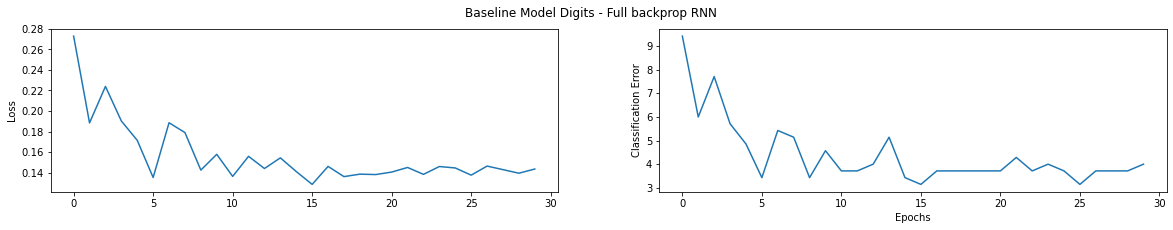

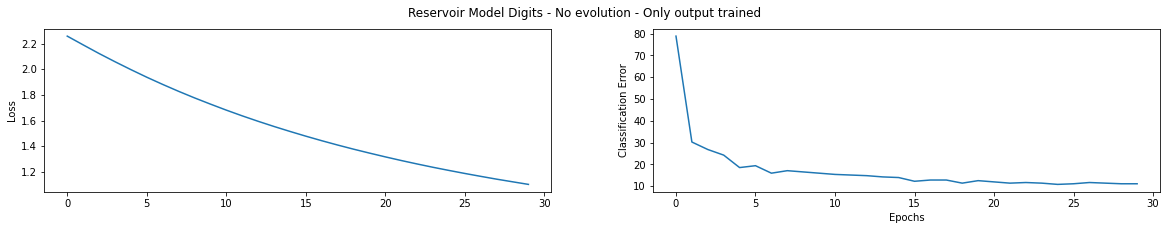

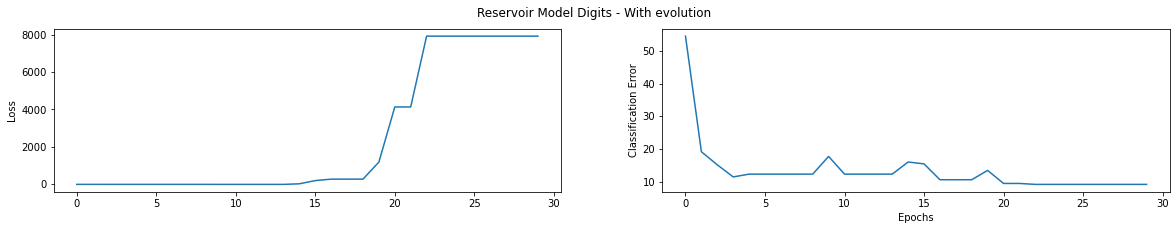

In [102]:
# Plot baseline - full backprop
plot_results(trained_bl_digits['epoch'], 
             trained_bl_digits['loss_results'], 
             trained_bl_digits['class_error_results'],
            'Baseline Model Digits - Full backprop RNN')

# Plot reservoir - no evolution yet
plot_results(trained_res_digits['epoch'], 
             trained_res_digits['loss_results'], 
             trained_res_digits['class_error_results'],
            'Reservoir Model Digits - No evolution - Only output trained')

# Plot reservoir - with evolution - best model
plot_results(best_pop_digits[0]['epoch'], 
             best_pop_digits[0]['loss_results'], 
             best_pop_digits[0]['class_error_results'],
            'Reservoir Model Digits - With evolution')


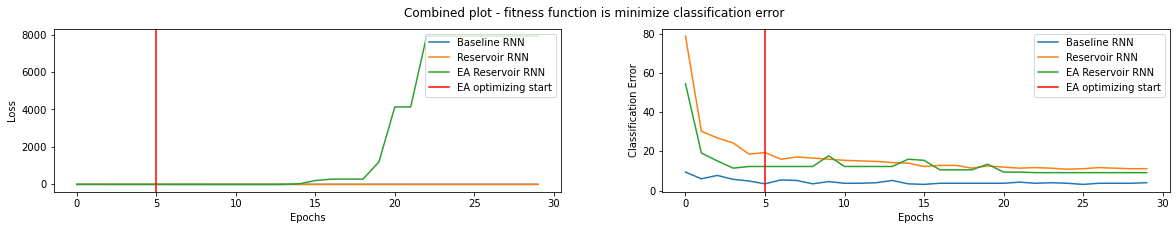

In [103]:
# Plot above plots in one plot
combined_plot_result(
            trained_bl_digits['epoch'],
            trained_bl_digits['loss_results'], 
            trained_bl_digits['class_error_results'],
            trained_res_digits['loss_results'], 
            trained_res_digits['class_error_results'],
            best_pop_digits[0]['loss_results'], 
            best_pop_digits[0]['class_error_results'],
            border = backprop_epochs,
            label_bl = 'Baseline RNN',
            label_res = 'Reservoir RNN',
            label_evo = 'EA Reservoir RNN',
            title = 'Combined plot - fitness function is minimize classification error')

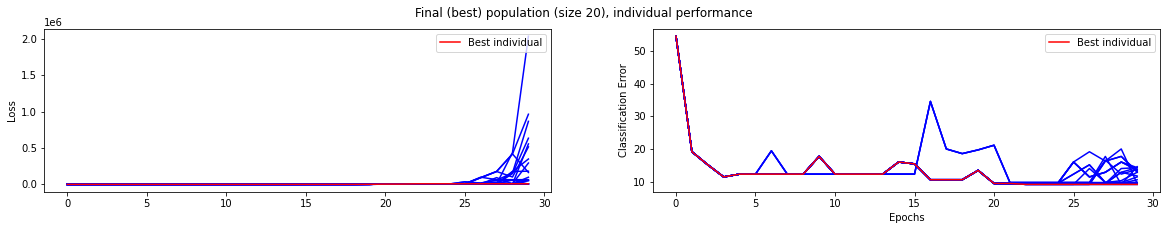

In [107]:
best_pop_plot(best_pop_digits, 
              best_pop_digits[0], 
              title='Final (best) population (size %s), individual performance' %(population_size))

### Overview of the models structure

In [143]:
# Baseline RNN model
print(summary(bl_model_digits, torch.zeros(1, 64), show_input=True, show_hierarchical=False))

# Reservoir RNN model
print(summary(res_model_digits, torch.zeros(1, 64), show_input=True, show_hierarchical=False))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1            [1, 128]          16,512          16,512
            Tanh-2            [1, 128]               0               0
          Linear-3            [1, 192]          24,704          24,704
            ReLU-4            [1, 128]               0               0
          Linear-5            [1, 192]          24,704          24,704
            ReLU-6            [1, 128]               0               0
          Linear-7            [1, 192]          24,704          24,704
            ReLU-8            [1, 128]               0               0
          Linear-9            [1, 192]          24,704          24,704
           ReLU-10            [1, 128]               0               0
         Linear-11            [1, 192]          24,704          24,704
           ReLU-12            [1, 128]               0               0
     

### Next: MNIST , will take a long time to process

In [36]:
train_loader_mnist, val_loader_mnist, test_loader_mnist = get_mnist_loaders(batch_size=50)

Training started for 3 epochs.
Epoch: 0 - Loss of: 1.755138614654541 - Accuracy of: 68.9800033569336
Epoch: 1 - Loss of: 1.4317982746124267 - Accuracy of: 73.20999908447266
Epoch: 2 - Loss of: 1.2342215896606445 - Accuracy of: 76.11000061035156
Training started for 3 epochs.
Epoch: 0 - Loss of: 1.8054981407165527 - Accuracy of: 70.06999969482422
Epoch: 1 - Loss of: 1.4960727081298828 - Accuracy of: 74.5199966430664
Epoch: 2 - Loss of: 1.2995541355133056 - Accuracy of: 76.58000183105469
Training started for 3 epochs.
Epoch: 0 - Loss of: 1.720561148071289 - Accuracy of: 72.8499984741211
Epoch: 1 - Loss of: 1.384822617340088 - Accuracy of: 75.5999984741211
Epoch: 2 - Loss of: 1.184612565612793 - Accuracy of: 77.86000061035156
Training started for 3 epochs.
Epoch: 0 - Loss of: 1.762764193725586 - Accuracy of: 72.52999877929688
Epoch: 1 - Loss of: 1.436917936706543 - Accuracy of: 75.43000030517578
Epoch: 2 - Loss of: 1.2341013305664061 - Accuracy of: 77.23999786376953
Training started for 3

Epoch: 6 - Loss of: 1.215914181137085 - Accuracy of: 77.69000244140625
Epoch: 6 - Loss of: 1.2159141803741456 - Accuracy of: 77.69000244140625
Parent / child ratio = 1 : 3
Possible candidates for optimization
Epoch: 7 - Loss of: 1.253518717956543 - Accuracy of: 75.43000030517578
Epoch: 7 - Loss of: 1.3294248764038086 - Accuracy of: 75.94000244140625
Epoch: 7 - Loss of: 1.2269399353027344 - Accuracy of: 76.5
Epoch: 7 - Loss of: 1.2706974910736084 - Accuracy of: 74.19000244140625
Epoch: 7 - Loss of: 1.2159141899108887 - Accuracy of: 77.69000244140625
Epoch: 7 - Loss of: 1.2159141925811767 - Accuracy of: 77.69000244140625
Epoch: 7 - Loss of: 1.2159141819000243 - Accuracy of: 77.69000244140625
Epoch: 7 - Loss of: 1.2159141826629638 - Accuracy of: 77.69000244140625
Epoch: 7 - Loss of: 1.215914182281494 - Accuracy of: 77.69000244140625
Epoch: 7 - Loss of: 1.2159142013549804 - Accuracy of: 77.69000244140625
Epoch: 7 - Loss of: 1.2535187297821044 - Accuracy of: 75.43000030517578
Epoch: 7 - Los

Epoch: 12 - Loss of: 1.2159141868591308 - Accuracy of: 77.69000244140625
Epoch: 12 - Loss of: 1.2159141929626465 - Accuracy of: 77.69000244140625
Epoch: 12 - Loss of: 1.2159141956329347 - Accuracy of: 77.69000244140625
Epoch: 12 - Loss of: 1.2200220012664795 - Accuracy of: 78.43000030517578
Epoch: 12 - Loss of: 1.2587751365661621 - Accuracy of: 75.22000122070312
Epoch: 12 - Loss of: 1.2187154899597168 - Accuracy of: 78.5199966430664
Epoch: 12 - Loss of: 1.2992767944335937 - Accuracy of: 75.25
Epoch: 12 - Loss of: 1.2114574371337892 - Accuracy of: 75.83000183105469
Epoch: 12 - Loss of: 1.2480082843780518 - Accuracy of: 75.04000091552734
Epoch: 12 - Loss of: 1.2159141819000243 - Accuracy of: 77.69000244140625
Epoch: 12 - Loss of: 1.2159141975402832 - Accuracy of: 77.69000244140625
Epoch: 12 - Loss of: 1.215914197921753 - Accuracy of: 77.69000244140625
Epoch: 12 - Loss of: 1.2159141792297363 - Accuracy of: 77.69000244140625
Parent / child ratio = 1 : 3
Possible candidates for optimization

Epoch: 17 - Loss of: 1.2187154754638672 - Accuracy of: 78.5199966430664
Epoch: 17 - Loss of: 1.2187154865264893 - Accuracy of: 78.5199966430664
Epoch: 17 - Loss of: 1.2187154891967773 - Accuracy of: 78.5199966430664
Parent / child ratio = 1 : 3
Possible candidates for optimization
Epoch: 18 - Loss of: 1.22276928024292 - Accuracy of: 76.5199966430664
Epoch: 18 - Loss of: 1.2531235172271729 - Accuracy of: 75.08000183105469
Epoch: 18 - Loss of: 1.2187154850006103 - Accuracy of: 78.5199966430664
Epoch: 18 - Loss of: 1.2187154884338378 - Accuracy of: 78.5199966430664
Epoch: 18 - Loss of: 1.2187154930114745 - Accuracy of: 78.5199966430664
Epoch: 18 - Loss of: 1.2187154861450196 - Accuracy of: 78.5199966430664
Epoch: 18 - Loss of: 1.2187155044555664 - Accuracy of: 78.5199966430664
Epoch: 18 - Loss of: 1.2187154857635498 - Accuracy of: 78.5199966430664
Epoch: 18 - Loss of: 1.21871548538208 - Accuracy of: 78.5199966430664
Epoch: 18 - Loss of: 1.2187154861450196 - Accuracy of: 78.5199966430664
E

Epoch: 23 - Loss of: 1.2187154720306397 - Accuracy of: 78.5199966430664
Epoch: 23 - Loss of: 1.2187154815673829 - Accuracy of: 78.5199966430664
Epoch: 23 - Loss of: 1.2187154815673829 - Accuracy of: 78.5199966430664
Epoch: 23 - Loss of: 1.2187154808044434 - Accuracy of: 78.5199966430664
Epoch: 23 - Loss of: 1.2501686447143554 - Accuracy of: 77.22000122070312
Epoch: 23 - Loss of: 1.2786843395233154 - Accuracy of: 75.94000244140625
Epoch: 23 - Loss of: 1.2187154861450196 - Accuracy of: 78.5199966430664
Epoch: 23 - Loss of: 1.2187154998779297 - Accuracy of: 78.5199966430664
Epoch: 23 - Loss of: 1.218715488052368 - Accuracy of: 78.5199966430664
Epoch: 23 - Loss of: 1.2187154808044434 - Accuracy of: 78.5199966430664
Epoch: 23 - Loss of: 1.2187154857635498 - Accuracy of: 78.5199966430664
Epoch: 23 - Loss of: 1.2187154712677002 - Accuracy of: 78.5199966430664
Epoch: 23 - Loss of: 1.2187154941558838 - Accuracy of: 78.5199966430664
Epoch: 23 - Loss of: 1.2187154842376708 - Accuracy of: 78.51999

Epoch: 28 - Loss of: 1.2187154987335205 - Accuracy of: 78.5199966430664
Epoch: 28 - Loss of: 1.218715489578247 - Accuracy of: 78.5199966430664
Epoch: 28 - Loss of: 1.2187154747009277 - Accuracy of: 78.5199966430664
Epoch: 28 - Loss of: 1.2187154861450196 - Accuracy of: 78.5199966430664
Parent / child ratio = 1 : 3
Possible candidates for optimization
Epoch: 29 - Loss of: 1.2460783321380615 - Accuracy of: 75.62999725341797
Epoch: 29 - Loss of: 1.2658939601898194 - Accuracy of: 75.05000305175781
Epoch: 29 - Loss of: 1.2187154914855958 - Accuracy of: 78.5199966430664
Epoch: 29 - Loss of: 1.2187154991149902 - Accuracy of: 78.5199966430664
Epoch: 29 - Loss of: 1.2187154941558838 - Accuracy of: 78.5199966430664
Epoch: 29 - Loss of: 1.2187154857635498 - Accuracy of: 78.5199966430664
Epoch: 29 - Loss of: 1.2187154914855958 - Accuracy of: 78.5199966430664
Epoch: 29 - Loss of: 1.218715483856201 - Accuracy of: 78.5199966430664
Epoch: 29 - Loss of: 1.218715486907959 - Accuracy of: 78.5199966430664

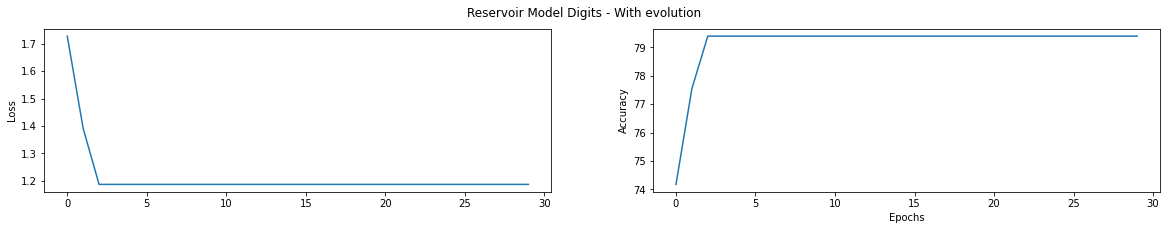

In [39]:
# Load in mnist
# Takes a lot of time

# Initialize population - train by backprop for a few epochs. 
reservoir_set_mnist = []
ea = EA(population_size, val_loader_mnist, loss_function, input_size_mnist, reservoir_size, n_labels)

for i in range(population_size):
    res_evo_mnist = Reservoir_RNN(input_size_mnist, reservoir_size, n_labels, T, dataset = 'MNIST')
    optimizer_evo_mnist = optim.SGD([p for p in res_evo_mnist.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
    trained_evo_mnist = training(res_evo_mnist, train_loader_mnist, val_loader_mnist, backprop_epochs, optimizer_evo_mnist, loss_function, max_loss_iter)
    reservoir_set_mnist.append(trained_evo_mnist)
        
# Initialize the population
new_pop = reservoir_set_mnist

# Perform ea steps
for i in range(generations):
    new_pop = ea.step(new_pop, mutate_opt, select_opt, select_mech, offspring_ratio, sample_dist)

# Sort population after x amount of generations, based on accuracy or loss performance
if select_opt == 'classification_error':
    best_pop_mnist = sorted(new_pop, key=lambda k: k['class_error_results'][-1] , reverse=False) 
elif select_opt == 'loss':
    best_pop_mnist = sorted(new_pop, key=lambda k: k['loss_results'][-1] , reverse=False)
    
plot_results(best_pop_mnist[0]['epoch'], 
             best_pop_mnist[0]['loss_results'], 
             best_pop_mnist[0]['class_error_results'],
            'Reservoir Model Digits - With evolution')